# **TECNICATURA UNIVERSITARIA EN INTELIGENCIA ARTIFICIAL**
## TRABAJO PRÁCTICO N° 1: APRENDIZAJE AUTOMÁTICO II
### Rosito, Valentín - (R-4662/1)
### **Fecha Límite de Entrega:** 07/12/2025
### **Semestre:** 2° Semestre 2025

---

## 1. Configuración del Entorno

Este notebook implementa un asistente virtual RAG (Retrieval-Augmented Generation) que combina tres tipos de bases de datos:
- **Base Vectorial**: ChromaDB con sentence-transformers para búsquedas semánticas
- **Base Tabular**: Pandas para consultas sobre inventario y precios
- **Base de Grafos**: **Memgraph con Neo4j driver** para relaciones entre productos

### ⚠️ Requisito importante: Memgraph
Para la sección de base de datos de grafos, necesitas tener Memgraph corriendo:

**Opción 1 - Docker (Recomendado)**:
```bash
docker run -p 7687:7687 memgraph/memgraph
```

**Opción 2 - Instalación nativa**:
Descarga desde: https://memgraph.com/download

### 1.1 Instalación de Dependencias


### 1.2 Importación de Librerías

In [2]:
import os
import json
import warnings
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import chromadb
from chromadb.config import Settings

# Driver de Neo4j para conectarse a Memgraph
from neo4j import GraphDatabase

from langchain_core.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

/Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos/.venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


### 1.3 Configuración de Rutas y Constantes

In [3]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
METADATA_DIR = PROCESSED_DATA_DIR / "metadata"
CHROMA_DB_DIR = PROCESSED_DATA_DIR / "chroma_db"

PRODUCTOS_CSV = RAW_DATA_DIR / "productos.csv"
FAQS_JSON = RAW_DATA_DIR / "faqs.json"
TICKETS_CSV = RAW_DATA_DIR / "tickets_soporte.csv"
MANUALES_DIR = RAW_DATA_DIR / "manuales_productos"
RESENAS_DIR = RAW_DATA_DIR / "resenas_usuarios"

FUNCIONES_CONTEXT = METADATA_DIR / "funciones_disponibles_for_llm.txt"
SCHEMA_CONTEXT = METADATA_DIR / "schema_context_for_llm.txt"

COLLECTION_NAME = "electrodomesticos_docs"

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")



## 2. Base Vectorial - ChromaDB

Esta sección implementa la búsqueda semántica usando ChromaDB. ChromaDB utiliza automáticamente el modelo `all-MiniLM-L6-v2` para generar embeddings, por lo que no necesitamos cargar el modelo manualmente.

**Fuentes de información:**
- Manuales de productos
- FAQs
- Tickets de soporte
- Reseñas de usuarios

### 2.1 Inicialización de ChromaDB

In [4]:
CHROMA_DB_DIR.mkdir(parents=True, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=str(CHROMA_DB_DIR))

print(f"ChromaDB inicializado")

# Crear o obtener colección
try:
    collection = chroma_client.get_collection(name=COLLECTION_NAME)
    print(f"\nColección '{COLLECTION_NAME}' cargada")
    print(f"  Documentos en colección: {collection.count()}")
except:
    collection = chroma_client.create_collection(
        name=COLLECTION_NAME,
        metadata={"description": "Documentación y contenido de electrodomésticos"}
    )
    print(f"\nColección '{COLLECTION_NAME}' creada")

ChromaDB inicializado

Colección 'electrodomesticos_docs' cargada
  Documentos en colección: 10165


### 2.2 Funciones de Carga de Documentos

In [5]:
def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50) -> List[str]:
    """
    Divide un texto en chunks con overlap para mejor contexto.
    
    Args:
        text: Texto a dividir
        chunk_size: Tamaño aproximado de cada chunk en caracteres
        overlap: Cantidad de caracteres que se solapan entre chunks
    
    Returns:
        Lista de chunks de texto
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if chunk:
            chunks.append(chunk)
    
    return chunks

def load_manuales() -> List[Dict[str, Any]]:
    """Carga todos los manuales de productos."""
    documentos = []
    
    if not MANUALES_DIR.exists():
        print(f"Directorio de manuales no encontrado: {MANUALES_DIR}")
        return documentos
    
    for manual_file in MANUALES_DIR.glob("*.md"):
        try:
            with open(manual_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = manual_file.stem.split('_')[1] if '_' in manual_file.stem else "unknown"
            
            # Dividir en chunks
            chunks = chunk_text(contenido, chunk_size=500, overlap=50)
            
            for idx, chunk in enumerate(chunks):
                documentos.append({
                    'id': f"manual_{product_id}_chunk_{idx}",
                    'text': chunk,
                    'metadata': {
                        'tipo': 'manual',
                        'producto_id': product_id,
                        'archivo': manual_file.name,
                        'chunk': idx
                    }
                })
        except Exception as e:
            print(f"Error cargando {manual_file.name}: {e}")
    
    return documentos

def load_faqs() -> List[Dict[str, Any]]:
    """Carga las FAQs desde el archivo JSON."""
    documentos = []
    
    if not FAQS_JSON.exists():
        print(f"⚠ Archivo FAQs no encontrado: {FAQS_JSON}")
        return documentos
    
    try:
        with open(FAQS_JSON, 'r', encoding='utf-8') as f:
            faqs = json.load(f)
        
        for idx, faq in enumerate(faqs):
            # Combinar pregunta y respuesta
            texto = f"Pregunta: {faq.get('pregunta', '')}\nRespuesta: {faq.get('respuesta', '')}"
            
            documentos.append({
                'id': f"faq_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'faq',
                    'categoria': faq.get('categoria', 'general')
                }
            })
    except Exception as e:
        print(f"Error cargando FAQs: {e}")
    
    return documentos

def load_tickets() -> List[Dict[str, Any]]:
    """Carga los tickets de soporte."""
    documentos = []
    
    if not TICKETS_CSV.exists():
        print(f"Archivo tickets no encontrado: {TICKETS_CSV}")
        return documentos
    
    try:
        df_tickets = pd.read_csv(TICKETS_CSV)
        
        for idx, row in df_tickets.iterrows():
            # Combinar problema y solución
            texto = f"Problema: {row.get('problema', '')}\nSolución: {row.get('solucion', '')}"
            
            documentos.append({
                'id': f"ticket_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'ticket',
                    'producto_id': row.get('id_producto', 'unknown'),
                    'estado': row.get('estado', 'unknown')
                }
            })
    except Exception as e:
        print(f"Error cargando tickets: {e}")
    
    return documentos

def load_resenas() -> List[Dict[str, Any]]:
    """Carga las reseñas de usuarios."""
    documentos = []
    
    if not RESENAS_DIR.exists():
        print(f" Directorio de reseñas no encontrado: {RESENAS_DIR}")
        return documentos
    
    for resena_file in RESENAS_DIR.glob("*.txt"):
        try:
            with open(resena_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = resena_file.stem.replace('resenas_', '')
            
            documentos.append({
                'id': f"resena_{product_id}",
                'text': contenido,
                'metadata': {
                    'tipo': 'resena',
                    'producto_id': product_id
                }
            })
        except Exception as e:
            print(f"Error cargando {resena_file.name}: {e}")
    
    return documentos

### 2.3 Carga de Documentos en ChromaDB

In [6]:
def populate_vector_db():
    """Carga todos los documentos en ChromaDB."""
    
    # Cargar todos los documentos
    all_docs = []
    
    print("\n1. Cargando manuales...")
    manuales = load_manuales()
    print(f"   {len(manuales)} chunks de manuales cargados")
    all_docs.extend(manuales)
    
    print("\n2. Cargando FAQs...")
    faqs = load_faqs()
    print(f"   {len(faqs)} FAQs cargadas")
    all_docs.extend(faqs)
    
    print("\n3. Cargando tickets de soporte...")
    tickets = load_tickets()
    print(f"   {len(tickets)} tickets cargados")
    all_docs.extend(tickets)
    
    print("\n4. Cargando reseñas...")
    resenas = load_resenas()
    print(f"   {len(resenas)} reseñas cargadas")
    all_docs.extend(resenas)
    
    if not all_docs:
        print("No se encontraron documentos para cargar")
        return
    
    print(f"\nTotal de documentos: {len(all_docs)}")
    
    ids = [doc['id'] for doc in all_docs]
    texts = [doc['text'] for doc in all_docs]
    metadatas = [doc['metadata'] for doc in all_docs]
    
    print("\nInsertando documentos en ChromaDB...")
    
    batch_size = 100
    for i in range(0, len(all_docs), batch_size):
        batch_end = min(i + batch_size, len(all_docs))
        
        collection.add(
            ids=ids[i:batch_end],
            documents=texts[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )
        
        print(f"Procesados {batch_end}/{len(all_docs)} documentos")
        
    print(f"\nBase vectorial poblada exitosamente")
    print(f"Total documentos en colección: {collection.count()}")


if collection.count() == 0:
    populate_vector_db()
else:
    print(f"ase vectorial ya contiene {collection.count()} documentos")
    print("Para recargar, elimina la colección primero")

ase vectorial ya contiene 10165 documentos
Para recargar, elimina la colección primero


### 2.4 Función de Búsqueda Semántica

In [7]:
def semantic_search(query: str, n_results: int = 5, filter_tipo: Optional[str] = None) -> Dict[str, Any]:
    """
    Realiza búsqueda semántica en la base vectorial.
    ChromaDB genera automáticamente el embedding de la query usando all-MiniLM-L6-v2.
    
    Args:
        query: Consulta del usuario
        n_results: Número de resultados a retornar
        filter_tipo: Filtrar por tipo de documento ('manual', 'faq', 'ticket', 'resena')
    
    Returns:
        Dict con resultados de la búsqueda
    """
    # Preparar filtro si es necesario
    where_clause = {"tipo": filter_tipo} if filter_tipo else None
    
    # ChromaDB genera automáticamente el embedding de la query
    results = collection.query(
        query_texts=[query],
        n_results=n_results,
        where=where_clause
    )
    
    # Formatear resultados
    formatted_results = {
        'query': query,
        'n_results': len(results['ids'][0]),
        'documents': []
    }
    
    for i in range(len(results['ids'][0])):
        formatted_results['documents'].append({
            'id': results['ids'][0][i],
            'text': results['documents'][0][i],
            'metadata': results['metadatas'][0][i],
            'distance': results['distances'][0][i] if 'distances' in results else None
        })
    
    return formatted_results

## 3. Base Tabular - Pandas DataFrame

Esta sección implementa consultas estructuradas sobre el inventario de productos:
- Filtrado por precio, stock, categoría
- Comparación de productos
- Análisis de disponibilidad

### 3.1 Carga del DataFrame de Productos

In [8]:
df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"{len(df_productos)} productos cargados")
print(f"\nColumnas disponibles:")
for col in df_productos.columns:
    print(f"  - {col}")

print(f"\nEjemplo de productos:")
df_productos.head(3)

300 productos cargados

Columnas disponibles:
  - id_producto
  - nombre
  - categoria
  - subcategoria
  - marca
  - precio_usd
  - stock
  - color
  - potencia_w
  - capacidad
  - voltaje
  - peso_kg
  - garantia_meses
  - descripcion

Ejemplo de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,220V,35.9,36,"Descubrí el poder de la Licuadora de TechHome,..."
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...


### 3.2 Análisis Exploratorio del DataFrame

INFORMACIÓN DEL DATASET
Total de productos: 300
Categorías: 4
Marcas: 17


DISTRIBUCIÓN POR CATEGORÍA
categoria
Cocina           147
Climatización     81
Lavado            70
Audio y Video      2
Name: count, dtype: int64


ESTADÍSTICAS DE PRECIOS (USD)
count     300.000000
mean     1481.669567
std       845.525639
min        28.220000
25%       836.260000
50%      1409.915000
75%      2142.560000
max      2992.330000
Name: precio_usd, dtype: float64


ESTADÍSTICAS DE STOCK
count    300.000000
mean      99.950000
std       58.354534
min        1.000000
25%       48.250000
50%      100.000000
75%      150.000000
max      200.000000
Name: stock, dtype: float64


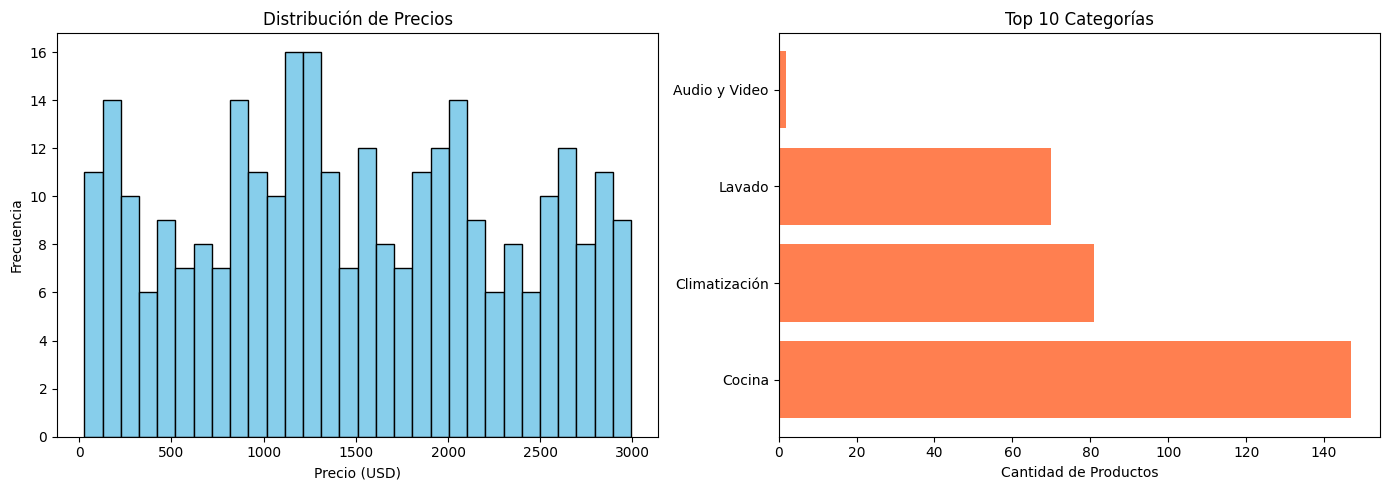

In [9]:
# Información del DataFrame
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Total de productos: {len(df_productos)}")
print(f"Categorías: {df_productos['categoria'].nunique()}")
print(f"Marcas: {df_productos['marca'].nunique()}")

print("\n\nDISTRIBUCIÓN POR CATEGORÍA")
print("=" * 60)
print(df_productos['categoria'].value_counts())

print("\n\nESTADÍSTICAS DE PRECIOS (USD)")
print("=" * 60)
print(df_productos['precio_usd'].describe())

print("\n\nESTADÍSTICAS DE STOCK")
print("=" * 60)
print(df_productos['stock'].describe())

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de precios
axes[0].hist(df_productos['precio_usd'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Precios')
axes[0].set_xlabel('Precio (USD)')
axes[0].set_ylabel('Frecuencia')

# Top 10 categorías
top_categorias = df_productos['categoria'].value_counts().head(10)
axes[1].barh(range(len(top_categorias)), top_categorias.values, color='coral')
axes[1].set_yticks(range(len(top_categorias)))
axes[1].set_yticklabels(top_categorias.index)
axes[1].set_title('Top 10 Categorías')
axes[1].set_xlabel('Cantidad de Productos')

plt.tight_layout()
plt.show()

In [10]:
df_productos.groupby('categoria')['precio_usd'].mean().sort_values(ascending=False)

categoria
Climatización    1599.313704
Lavado           1509.291429
Cocina           1412.248776
Audio y Video     852.745000
Name: precio_usd, dtype: float64

### 3.2.1 Análisis de Variables Categóricas y Continuas
----
> Variables como `capacidad` y `voltaje` son strings conformadas en este formato (30L, 220V) respectivamente. O algunos casos en `voltaje` donde algun registro está en el formato: "110-220V".

In [11]:
resumen = {
    'CATEGÓRICAS': {},
    'CONTINUAS': {}
}

for var in ['categoria', 'subcategoria', 'marca', 'color', 'voltaje', 'capacidad']:
    if var in df_productos.columns:
        valores = sorted([str(v) for v in df_productos[var].unique() if pd.notna(v)])
        resumen['CATEGÓRICAS'][var] = valores

for var in ['precio_usd', 'stock', 'potencia_w', 'peso_kg', 'garantia_meses']:
    if var in df_productos.columns:
        valores = df_productos[var].dropna()
        if len(valores) > 0:
            resumen['CONTINUAS'][var] = {
                'min': valores.min(),
                'mediana': valores.median(),
                'max': valores.max()
            }

print("\n📊 VARIABLES CATEGÓRICAS:")
print("─" * 80)
for var, valores in resumen['CATEGÓRICAS'].items():
    print(f"\n{var}: ({len(valores)} valores únicos)")
    print(f"  {', '.join(valores[:10])}")
    if len(valores) > 10:
        print(f"  ... y {len(valores) - 10} más")

print("\n\n📈 VARIABLES CONTINUAS:")
print("─" * 80)
for var, stats in resumen['CONTINUAS'].items():
    print(f"\n{var}:")
    print(f"  Mínimo: {stats['min']:,.2f} | Mediana: {stats['mediana']:,.2f} | Máximo: {stats['max']:,.2f}")


📊 VARIABLES CATEGÓRICAS:
────────────────────────────────────────────────────────────────────────────────

categoria: (4 valores únicos)
  Audio y Video, Climatización, Cocina, Lavado

subcategoria: (13 valores únicos)
  Aires Acondicionados, Calefacción, Cocción, Lavado de Ropa, Lavado de Vajilla, Pequeños Electrodomésticos, Planchado, Preparación, Purificación, Refrigeración
  ... y 3 más

marca: (17 valores únicos)
  AirFlow, ChefMaster, CleanMaster, ClimaTech, CookElite, EcoClima, FreshWash, HomeChef, KitchenPro, LaundryTech
  ... y 7 más

color: (10 valores únicos)
  Amarillo, Azul, Blanco, Dorado, Gris, Negro, Plateado, Rojo, Rosa, Verde

voltaje: (3 valores únicos)
  110-220V, 12V, 220V

capacidad: (20 valores únicos)
  1.0L, 1.2L, 1.5L, 1.8L, 10kg, 12kg, 2.0L, 2.5L, 200L, 3.0L
  ... y 10 más


📈 VARIABLES CONTINUAS:
────────────────────────────────────────────────────────────────────────────────

precio_usd:
  Mínimo: 28.22 | Mediana: 1,409.91 | Máximo: 2,992.33

stock:
  Míni

### 3.2.2 Contexto y almacenamiento para LLM

> En este caso, almacené en un .txt la siguiente información sobre la **base de datos tabular**:

    - nombre_dataset: nombre del dataset (string).
    - total_registros: cantidad total de filas en df_productos (int).
    - columnas: lista con los nombres de las columnas del DataFrame (lista de strings).
    - descripcion_general: descripción textual del dataset.


**variables_categoricas**: objeto donde cada variable categórica (ej. categoria, subcategoria, marca, color, voltaje, capacidad) tiene:

    - tipo: "categorical"
    - valores_unicos: lista ordenada de valores únicos (strings)
    - cantidad_valores: número de valores únicos (int)

**variables_continuas**: objeto donde cada variable numérica (ej. precio_usd, stock, potencia_w, peso_kg, garantia_meses) tiene:

    - tipo: "numeric"
    - minimo: valor mínimo (float)
    - maximo: valor máximo (float)
    - mediana: mediana (float)

> Decidí mantener este contexto **(≈700 tokens)** porque, comparado con la **ventana de contexto de Gemini 2.0 Flash (≈1,000,000 tokens)**, es insignificante y útil para el LLM.

---


## **Estrategia de Consulta con LLM:**

El LLM recibirá dos contextos:
1. **Schema del dataset** (`schema_context_for_llm.txt`): Información sobre variables categóricas y numéricas (Convertido del JSON creado previamente)
2. **Funciones disponibles** (`funciones_disponibles_for_llm.txt`): Especificación de las 8 funciones disponibles con ejemplos de JSON

El LLM analizará la consulta del usuario y retornará un JSON con:
- `funcion`: nombre de la función a ejecutar
- `parametros`: diccionario con los parámetros a pasar

Este enfoque permite que el LLM actúe como un **router inteligente** que traduce lenguaje natural a llamadas de función estructuradas.

In [12]:
def get_schema_metadata_for_llm() -> str:
    """
    Retorna los metadatos del schema en formato texto optimizado para LLM.
    Este contexto será usado por el LLM para elegir qué función llamar.
    
    Returns:
        String con la descripción completa del schema para contexto del LLM
    """
    with open(SCHEMA_CONTEXT, 'r', encoding='utf-8') as f:
      schema_text = f.read()

    return schema_text


def get_funciones_disponibles_for_llm() -> str:
    """
    Retorna la documentación de las funciones disponibles para que el LLM 
    pueda elegir cuál usar y con qué parámetros.
    
    Returns:
        String con la especificación de las funciones disponibles
    """
    with open(FUNCIONES_CONTEXT, 'r', encoding='utf-8') as f:
      funciones_spec = f.read()
    
    return funciones_spec

In [13]:
llm_schema_context = get_schema_metadata_for_llm()
llm_funciones_context = get_funciones_disponibles_for_llm()

print(f"\nArchivo 1: Schema del Dataset")
print(f"  Tamaño: {len(llm_schema_context)} caracteres (~{len(llm_schema_context)//3} tokens)")

print(f"\nArchivo 2: Funciones Disponibles")
print(f"  Tamaño: {len(llm_funciones_context)} caracteres (~{len(llm_funciones_context)//3} tokens)")


Archivo 1: Schema del Dataset
  Tamaño: 1942 caracteres (~647 tokens)

Archivo 2: Funciones Disponibles
  Tamaño: 4151 caracteres (~1383 tokens)


### 3.3 Funciones de Consulta Tabular

In [14]:
def buscar_por_precio(precio_min: float = None, precio_max: float = None, 
                      categoria: str = None, subcategoria: str = None) -> pd.DataFrame:
    """
    Busca productos por rango de precio y opcionalmente por categoría y subcategoría.
    
    Args:
        precio_min: Precio mínimo
        precio_max: Precio máximo
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
    
    Returns:
        DataFrame con productos filtrados
    """
    df = df_productos.copy()
    
    if precio_min is not None:
        df = df[df['precio_usd'] >= precio_min]
    
    if precio_max is not None:
        df = df[df['precio_usd'] <= precio_max]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    return df.sort_values('precio_usd')

def buscar_por_stock(stock_min: int = 0, categoria: str = None, subcategoria: str = None) -> pd.DataFrame:
    """
    Busca productos con stock disponible.
    
    Args:
        stock_min: Stock mínimo requerido
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
    
    Returns:
        DataFrame con productos con stock
    """
    df = df_productos[df_productos['stock'] >= stock_min]

    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    return df.sort_values('stock', ascending=False)

def buscar_por_caracteristicas(marca: str = None, categoria: str = None, 
                               subcategoria: str = None, color: str = None) -> pd.DataFrame:
    """
    Busca productos por características específicas.
    
    Args:
        marca: Marca del producto
        categoria: Categoría
        subcategoria: Subcategoría
        color: Color del producto
    
    Returns:
        DataFrame con productos que cumplen los criterios
    """
    df = df_productos.copy()
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if color is not None:
        df = df[df['color'].str.contains(color, case=False, na=False)]
    
    return df

def comparar_productos(ids_productos: List[str]) -> pd.DataFrame:
    """
    Compara múltiples productos lado a lado.
    
    Args:
        ids_productos: Lista de IDs de productos a comparar
    
    Returns:
        DataFrame con comparación de productos
    """
    df = df_productos[df_productos['id_producto'].isin(ids_productos)]
    
    columnas_importantes = ['id_producto', 'nombre', 'marca', 'precio_usd', 
                           'stock', 'potencia_w', 'capacidad', 'garantia_meses']
    
    # Seleccionar solo columnas que existen
    columnas_existentes = [col for col in columnas_importantes if col in df.columns]
    
    return df[columnas_existentes].T

def productos_mas_baratos(n: int = 10, categoria: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más baratos.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
    
    Returns:
        DataFrame con los productos más baratos
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.nsmallest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def productos_mas_caros(n: int = 10, categoria: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más caros.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
    
    Returns:
        DataFrame con los productos más caros
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.nlargest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def obtener_categorias() -> List[str]:
    """Retorna lista de todas las categorías disponibles."""
    return sorted(df_productos['categoria'].unique().tolist())

def obtener_marcas() -> List[str]:
    """Retorna lista de todas las marcas disponibles."""
    return sorted(df_productos['marca'].unique().tolist())

### 3.4 Interfaz para Consultas con LLM

Esta interfaz permite que un LLM interprete consultas en lenguaje natural y las traduzca a llamadas de función estructuradas.

In [15]:
# Prompt para consulta con funciones

def crear_prompt_llm_template(schema_context: str = llm_schema_context,
                                funciones_context: str = llm_funciones_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde sólo `consulta_usuario` será variable
    al invocarlo.

    Usa las variables `llm_schema_context` y `llm_funciones_context` definidas
    en el notebook para fijar el contexto del prompt.
    """
    # Escapar llaves para que LangChain no las interprete como variables
    schema_escaped = schema_context.replace("{", "{{").replace("}", "}}")
    funciones_escaped = funciones_context.replace("{", "{{").replace("}", "}}")
    
    template = f"""{schema_escaped}

---

{funciones_escaped}

---

## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## TU RESPUESTA (SOLO JSON):
"""
    return PromptTemplate(input_variables=["consulta_usuario"], template=template)


# Prompt para descripción de resultados

def crear_prompt_llm_desc(schema_context: str = llm_schema_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde `consulta_usuario` e `informacion_recuperada`
    serán variables al invocarlo.

    Usa la variable `llm_schema_context` definida en el notebook para fijar el contexto del prompt.
    """
    # Escapar llaves para que LangChain no las interprete como variables
    schema_escaped = schema_context.replace("{", "{{").replace("}", "}}")
    
    template = f"""
# EN BASE A ESTE CONTEXTO DEL DATASET, LA PREGUNTA DEL USUARIO Y ESTA INFORMACION RECUPERADA DE UNA BASE DE DATOS TABULAR:

{schema_escaped}
---
## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## INFORMACION RECUPERADA DE LA BASE DE DATOS TABULAR:
{{informacion_recuperada}}


## DESCRIBE BREVE Y CONCISAMENTE LOS RESULTADOS OBTENIDOS:

## TU RESPUESTA (UNA DESCRIPCION BREVE):
"""
    return PromptTemplate(input_variables=["consulta_usuario", "informacion_recuperada"], template=template)


# Invocación de LLMs

def invocar_llm_desc(llm, consulta_usuario: str, informacion_recuperada: str) -> str:
    """
    Helper que crea una descripcion breve de los resultados obtenidos.
    Retorna el texto devuelto por el LLM.
    """
    prompt = crear_prompt_llm_desc()
    chain = prompt | llm
    return chain.invoke({
        "consulta_usuario": consulta_usuario,
        "informacion_recuperada": informacion_recuperada
    })

def invocar_llm_con_consulta(llm, consulta_usuario: str) -> str:
    """
    Helper que crea el chain y ejecuta la consulta.
    Retorna el texto devuelto por el LLM (puede ser JSON en texto).
    """
    prompt = crear_prompt_llm_template()
    chain = prompt | llm
    return chain.invoke({"consulta_usuario": consulta_usuario})


#### Funciones para consultar el Dataframe
---

In [16]:
FUNCIONES_DISPONIBLES = {
    'buscar_por_precio': buscar_por_precio,
    'buscar_por_stock': buscar_por_stock,
    'buscar_por_caracteristicas': buscar_por_caracteristicas,
    'comparar_productos': comparar_productos,
    'productos_mas_baratos': productos_mas_baratos,
    'productos_mas_caros': productos_mas_caros,
    'obtener_categorias': obtener_categorias,
    'obtener_marcas': obtener_marcas
}

def ejecutar_consulta_tabular(funcion_json: Dict[str, Any]) -> Any:
    """
    Ejecuta una consulta tabular basada en el JSON retornado por el LLM.

    Returns:
        Resultado de la función (generalmente un DataFrame)
    
    Raises:
        ValueError: Si la función no existe o hay errores en los parámetros
    """
    # Validar estructura del JSON
    if not isinstance(funcion_json, dict):
        raise ValueError("El input debe ser un diccionario")
    
    if 'funcion' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'funcion'")
    
    if 'parametros' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'parametros'")
    
    nombre_funcion = funcion_json['funcion']
    parametros = funcion_json['parametros']
    
    # Validar que la función existe
    if nombre_funcion not in FUNCIONES_DISPONIBLES:
        funciones_validas = ', '.join(FUNCIONES_DISPONIBLES.keys())
        raise ValueError(
            f"Función '{nombre_funcion}' no encontrada. "
            f"Funciones disponibles: {funciones_validas}"
        )
    
    funcion = FUNCIONES_DISPONIBLES[nombre_funcion]
    
    try:
        resultado = funcion(**parametros)
        return resultado
    except TypeError as e:
        raise ValueError(f"Error en los parámetros de '{nombre_funcion}': {str(e)}")
    except Exception as e:
        raise ValueError(f"Error ejecutando '{nombre_funcion}': {str(e)}")


def consulta_con_llm_tabular(llm, 
    consulta_usuario: str) -> Any:
    """
    Interfaz principal para realizar consultas en lenguaje natural sobre la base tabular.
    
    Esta función:
    1. Prepara el contexto (schema + funciones disponibles) para el LLM
    2. Envía la consulta del usuario al LLM
    3. El LLM retorna un JSON con la función y parámetros
    4. Ejecuta la función correspondiente
    5. Retorna el resultado

    Devuelve:
        Resultado de la consulta (generalmente un DataFrame)
    """
    
    # 2. Llamar al LLM
    try:
        respuesta_llm = invocar_llm_con_consulta(llm, consulta_usuario)
        # 3. Parsear JSON
        # El LLM puede retornar JSON en markdown (```json ... ```)
        respuesta_limpia = respuesta_llm.strip()
        
        # Limpiar markdown code blocks si existen
        if respuesta_limpia.startswith("```"):
            # Encontrar el contenido entre ``` y ```
            lineas = respuesta_limpia.split('\n')
            respuesta_limpia = '\n'.join(lineas[1:-1])
        
        funcion_json = json.loads(respuesta_limpia)

        # 4. Ejecutar la función
        resultado = ejecutar_consulta_tabular(funcion_json)

        desc = invocar_llm_desc(llm, consulta_usuario, str(resultado))

        return desc, resultado
        
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON del LLM: {str(e)}\nRespuesta: {respuesta_llm}")
    except Exception as e:
        raise ValueError(f"Error en la consulta: {str(e)}")

### Integracion y pruebas Google Gemini

A continuación se muestran ejemplos de uso de la interfaz

In [17]:
llm = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=api_key)

> Elegi este modelo, ya que estoy usando la API gratuita de Google y este permite 15 consultas por minuto. Además de ofrecer una alta precision y poser una amplia ventana de contexto de 1M de tokens.

In [18]:
print("=" * 80)
print("PRUEBA 1: Productos más baratos")
print("=" * 80)

resultado1, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Muéstrame los 5 productos más económicos",
)

print("\n📊 Resultados:")
print(resultado1)
display(data)

PRUEBA 1: Productos más baratos

📊 Resultados:
Los 5 productos más económicos son un lavavajillas WashPro (28.22 USD), un molinillo de café HomeChef (30.02 USD), un lavarropas CleanMaster (40.45 USD), una pava eléctrica HomeChef (47.86 USD) y una mixer ChefMaster (52.70 USD).

📊 Resultados:
Los 5 productos más económicos son un lavavajillas WashPro (28.22 USD), un molinillo de café HomeChef (30.02 USD), un lavarropas CleanMaster (40.45 USD), una pava eléctrica HomeChef (47.86 USD) y una mixer ChefMaster (52.70 USD).


,id_producto,nombre,marca,precio_usd,stock
273,P0274,Lavavajillas,WashPro,28.22,122
38,P0039,Premium Molinillo de Café,HomeChef,30.02,137
235,P0236,Lavarropas Semiautomático X,CleanMaster,40.45,78
123,P0124,Pava Eléctrica 2024,HomeChef,47.86,77
26,P0027,Mixer Pro,ChefMaster,52.70,159


In [19]:
print("=" * 80)
print("PRUEBA 2: Productos con stock disponible")
print("=" * 80)

resultado2, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="¿Qué productos tienen stock disponible?",
)

print(f"\n📊 Resultados:")
print(resultado2)
display(data)

PRUEBA 2: Productos con stock disponible

📊 Resultados:
La información recuperada muestra una lista de 300 productos electrodomésticos que tienen stock disponible (stock > 0). Se incluyen detalles como nombre, categoría, subcategoría, marca, precio, stock, color y otras características técnicas.

📊 Resultados:
La información recuperada muestra una lista de 300 productos electrodomésticos que tienen stock disponible (stock > 0). Se incluyen detalles como nombre, categoría, subcategoría, marca, precio, stock, color y otras características técnicas.


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
21,P0022,Advanced Batidora de Pie,Cocina,Preparación,KitchenPro,2781.38,200,Gris,1400.0,NaN,220V,49.3,18,Presentamos la Advanced Batidora de Pie de Kit...
285,P0286,Plancha Seca,Lavado,Planchado,WashPro,1580.93,200,Azul,200.0,NaN,220V,25.1,18,"Presentamos la Plancha Seca de WashPro, un pro..."
128,P0129,Exprimidor 2024,Cocina,Pequeños Electrodomésticos,ChefMaster,601.85,198,Verde,1800.0,NaN,12V,6.1,36,"Presentamos la Exprimidor 2024 de ChefMaster, ..."
291,P0292,Centro de Planchado,Lavado,Planchado,CleanMaster,2601.44,198,Azul,300.0,NaN,110-220V,3.9,24,Presentamos la Centro de Planchado de CleanMas...
268,P0269,Tender Eléctrico 3000,Lavado,Secado,WashPro,1756.31,198,Negro,1350.0,NaN,110-220V,47.5,18,Presentamos la Tender Eléctrico 3000 de WashPr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,P0229,Deluxe Lavarropas Automático 2024,Lavado,Lavado de Ropa,WashPro,191.93,2,Plateado,300.0,8kg,110-220V,19.2,24,Presentamos la Deluxe Lavarropas Automático 20...
93,P0094,Elite Heladera,Cocina,Refrigeración,CookElite,784.59,2,Gris,650.0,350L,110-220V,32.1,24,"Presentamos la Elite Heladera de CookElite, un..."
194,P0195,Ventilador de Torre 2024,Climatización,Ventilación,AirFlow,2633.30,2,Azul,90.0,NaN,110-220V,9.7,18,Presentamos la Ventilador de Torre 2024 de Air...
177,P0178,Panel Calefactor,Climatización,Calefacción,AirFlow,875.09,2,Negro,350.0,NaN,110-220V,25.0,24,"Presentamos la Panel Calefactor de AirFlow, un..."


In [20]:
print("=" * 80)
print("PRUEBA 3: Buscar refrigeradores por rango de precio")
print("=" * 80)

resultado3, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Dame de la subcategoria refrigeradores entre $400 y $700",
)

print(f"\n📊 Resultados:")
print(resultado3)
display(data.head(10))

PRUEBA 3: Buscar refrigeradores por rango de precio

📊 Resultados:
La consulta devuelve tres refrigeradores de la subcategoría "Refrigeración" con precios entre $400 y $700. Los productos son de las marcas ChefMaster y KitchenPro, con diferentes características como color, capacidad, voltaje y garantía.

📊 Resultados:
La consulta devuelve tres refrigeradores de la subcategoría "Refrigeración" con precios entre $400 y $700. Los productos son de las marcas ChefMaster y KitchenPro, con diferentes características como color, capacidad, voltaje y garantía.


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
92,P0093,Heladera,Cocina,Refrigeración,ChefMaster,530.69,20,Rosa,1850.0,500L,12V,34.2,12,"Presentamos la Heladera de ChefMaster, un prod..."
106,P0107,Smart Conservadora 2024,Cocina,Refrigeración,KitchenPro,635.48,195,Dorado,1250.0,NaN,220V,49.4,36,Presentamos la Smart Conservadora 2024 de Kitc...
117,P0118,Pro Vinoteca,Cocina,Refrigeración,ChefMaster,692.12,27,Verde,1800.0,NaN,220V,8.2,24,"Presentamos la Pro Vinoteca de ChefMaster, un ..."


In [21]:
print("=" * 80)
print("PRUEBA 4: Productos de marca KitchenPro")
print("=" * 80)

resultado4, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Muéstrame todos los productos KitchenPro disponibles",
)

print(f"\n📊 Resultados:")
print(resultado4)
display(data.head(10))

PRUEBA 4: Productos de marca KitchenPro

📊 Resultados:
Se muestran 28 productos de la marca KitchenPro, abarcando subcategorías como Preparación, Cocción, Refrigeración y Pequeños Electrodomésticos. Se incluye información detallada de cada producto como nombre, categoría, subcategoría, precio, stock, color, potencia, capacidad, voltaje, peso, garantía y descripción.

📊 Resultados:
Se muestran 28 productos de la marca KitchenPro, abarcando subcategorías como Preparación, Cocción, Refrigeración y Pequeños Electrodomésticos. Se incluye información detallada de cada producto como nombre, categoría, subcategoría, precio, stock, color, potencia, capacidad, voltaje, peso, garantía y descripción.


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
6,P0007,Licuadora,Cocina,Preparación,KitchenPro,2532.47,198,Blanco,1300.0,2.5L,12V,11.4,18,Descubrí el poder de la Licuadora de KitchenPr...
8,P0009,Procesadora,Cocina,Preparación,KitchenPro,1213.21,56,Plateado,900.0,2.5L,12V,21.7,36,La Procesadora de KitchenPro es tu aliada perf...
12,P0013,Procesadora,Cocina,Preparación,KitchenPro,82.93,92,Azul,1700.0,2.0L,220V,30.1,24,La Procesadora de KitchenPro es tu aliada perf...
13,P0014,Premium Picadora,Cocina,Preparación,KitchenPro,2303.35,32,Gris,1750.0,NaN,220V,48.9,36,"Presentamos la Premium Picadora de KitchenPro,..."
19,P0020,Batidora de Pie,Cocina,Preparación,KitchenPro,768.16,19,Gris,600.0,NaN,110-220V,9.6,24,"Presentamos la Batidora de Pie de KitchenPro, ..."
21,P0022,Advanced Batidora de Pie,Cocina,Preparación,KitchenPro,2781.38,200,Gris,1400.0,NaN,220V,49.3,18,Presentamos la Advanced Batidora de Pie de Kit...
24,P0025,Mixer,Cocina,Preparación,KitchenPro,757.48,152,Blanco,950.0,NaN,110-220V,6.4,36,"Presentamos la Mixer de KitchenPro, un product..."
33,P0034,Turbo Abridor de Latas,Cocina,Preparación,KitchenPro,2779.14,60,Plateado,1950.0,NaN,110-220V,48.7,12,Presentamos la Turbo Abridor de Latas de Kitch...
34,P0035,Profesional Abridor de Latas,Cocina,Preparación,KitchenPro,818.74,179,Negro,1250.0,NaN,110-220V,40.2,12,Presentamos la Profesional Abridor de Latas de...
46,P0047,Turbo Microondas,Cocina,Cocción,KitchenPro,1847.63,184,Dorado,1100.0,NaN,12V,16.2,24,"Presentamos la Turbo Microondas de KitchenPro,..."


In [22]:
print("=" * 80)
print("PRUEBA 5: Comparar productos específicos")
print("=" * 80)

resultado5, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Compara los productos P0001, P0002 y P0003",
)

print(f"\n📊 Resultados:")
print(resultado5)
display(data)

PRUEBA 5: Comparar productos específicos

📊 Resultados:
La tabla compara tres licuadoras de la marca TechHome. La "Licuadora" (P0001) y "Plus Licuadora Pro" (P0003) tienen precios similares (aproximadamente $284 y $329 respectivamente), potencias alrededor de 650-700W y capacidad de 1.2L. La "Licuadora" (P0001) tiene una garantía de 36 meses, mientras que la "Plus Licuadora Pro" (P0003) tiene una garantía de 18 meses. La "Licuadora" (P0002) es significativamente más cara ($1273), tiene menor potencia (300W) y mayor capacidad (2.0L), con una garantía de 36 meses. El stock de las tres es similar, alrededor de 100 unidades.

📊 Resultados:
La tabla compara tres licuadoras de la marca TechHome. La "Licuadora" (P0001) y "Plus Licuadora Pro" (P0003) tienen precios similares (aproximadamente $284 y $329 respectivamente), potencias alrededor de 650-700W y capacidad de 1.2L. La "Licuadora" (P0001) tiene una garantía de 36 meses, mientras que la "Plus Licuadora Pro" (P0003) tiene una garantía de 

,0,1,2
id_producto,P0001,P0002,P0003
nombre,Licuadora,Licuadora,Plus Licuadora Pro
marca,TechHome,TechHome,TechHome
precio_usd,283.63,1273.06,329.07
stock,108,114,97
potencia_w,650.0,300.0,700.0
capacidad,1.2L,2.0L,1.2L
garantia_meses,36,36,18


### **Arquitectura de la Interfaz**

Usuario escribe la consulta

    ↓
`consulta_con_llm_tabular()` prepara contexto

    ↓
LLM analiza y devuelve JSON con función + parámetros

    ↓
`ejecutar_consulta_tabular()` valida y ejecuta

    ↓
Retorna DataFrame con resultados

    ↓
Se genera una descripción.

---

#### **Ventajas de esta Arquitectura**

1. **Separación de Responsabilidades**: El LLM solo interpreta, no ejecuta código
2. **Seguridad**: Solo se pueden ejecutar funciones predefinidas
3. **Flexibilidad**: Fácil agregar nuevas funciones al diccionario
4. **Testing**: Se puede probar sin llamar al LLM (usando `llm_simulado`)
5. **Multi-LLM**: Compatible con cualquier LLM (Gemini, GPT-4, Claude, etc.)

---

#### **Cómo Agregar Nuevas Funciones**

```python
# 1. Define la función
def mi_nueva_funcion(...)

# 2. Agrégala al diccionario
FUNCIONES_DISPONIBLES['mi_nueva_funcion'] = mi_nueva_funcion

# 3. Documéntala en get_funciones_disponibles_for_llm()
```

#### **Contexto Enviado al LLM**

El LLM recibe:
- **Schema del dataset**: Variables categóricas y numéricas con sus valores posibles
- **Funciones disponibles**: 8 funciones documentadas con ejemplos de JSON
- **Consulta del usuario**: Texto en lenguaje natural

Total: ~3,000 tokens (0.3% de la ventana de Gemini 2.0 Flash)

---

## 4. Base de Datos de Grafos - Memgraph con Neo4j

Esta sección implementa una base de datos de grafos usando **Memgraph** accesible mediante el driver de Neo4j:
- **Nodos**: Productos con todas sus propiedades
- **Relaciones**: MISMA_CATEGORIA, MISMA_SUBCATEGORIA, MISMA_MARCA, SIMILAR_PRECIO, MISMO_VOLTAJE
- **Consultas Cypher**: Convertidas desde lenguaje natural usando LLM
- **Interface única**: Función que recibe consulta NL y devuelve resultados del grafo
- **Base de datos**: Memgraph corriendo en `bolt://localhost:7687`

### 4.1. Configuración de Memgraph con Neo4j Driver

La implementación usa el driver oficial de Neo4j para conectarse a Memgraph:
- Conexión a `bolt://localhost:7687`
- Soporte completo para consultas Cypher
- Gestión de transacciones y sesiones
- Base de datos: `memgraph`

In [23]:
from neo4j import GraphDatabase
import pandas as pd
from typing import List, Dict, Any, Optional, Tuple
import json

# Configuración de conexión a Memgraph
URI = "bolt://localhost:7687"
AUTH = ("", "")  # Sin autenticación por defecto en Memgraph

class MemgraphConnection:
    """
    Clase para manejar la conexión y operaciones con Memgraph usando el driver de Neo4j.
    Compatible con la sintaxis completa de Cypher.
    """
    
    def __init__(self, uri: str = URI, auth: tuple = AUTH):
        """
        Inicializa la conexión con Memgraph
        
        Args:
            uri: URI de conexión (bolt://localhost:7687)
            auth: Tupla con (usuario, password)
        """
        self.uri = uri
        self.auth = auth
        self.driver = None
        self._connect()
    
    def _connect(self):
        """Establece conexión con Memgraph"""
        try:
            self.driver = GraphDatabase.driver(self.uri, auth=self.auth)
            self.driver.verify_connectivity()
            print(f"✓ Conectado a Memgraph en {self.uri}")
        except Exception as e:
            print(f"✗ Error conectando a Memgraph: {e}")
            print("\nAsegúrate de que Memgraph esté corriendo:")
            print("  Docker: docker run -p 7687:7687 memgraph/memgraph")
            print("  O sigue las instrucciones en: https://memgraph.com/docs/getting-started")
            raise
    
    def close(self):
        """Cierra la conexión"""
        if self.driver:
            self.driver.close()
            print("Conexión cerrada")
    
    def execute_query(self, query: str, parameters: Dict = None) -> List[Dict]:
        """
        Ejecuta una query Cypher y devuelve los resultados
        
        Args:
            query: Query Cypher
            parameters: Parámetros para la query
        
        Returns:
            Lista de diccionarios con los resultados
        """
        if not self.driver:
            raise ConnectionError("No hay conexión activa con Memgraph")
        
        try:
            records, summary, keys = self.driver.execute_query(
                query,
                parameters_=parameters or {},
                database_="memgraph"
            )
            
            # Convertir registros a lista de diccionarios
            results = []
            for record in records:
                result_dict = {}
                for key in keys:
                    value = record[key]
                    # Convertir nodos a diccionarios
                    if hasattr(value, '__dict__'):
                        result_dict[key] = dict(value)
                    else:
                        result_dict[key] = value
                results.append(result_dict)
            
            return results
            
        except Exception as e:
            print(f"Error ejecutando query: {e}")
            return []
    
    def clear_database(self):
        """Limpia toda la base de datos"""
        try:
            self.execute_query("MATCH (n) DETACH DELETE n")
            print("✓ Base de datos limpiada")
        except Exception as e:
            print(f"✗ Error limpiando base de datos: {e}")
    
    def create_node(self, node_type: str, properties: Dict):
        """
        Crea un nodo en el grafo
        
        Args:
            node_type: Tipo de nodo (ej: "Producto")
            properties: Diccionario con propiedades del nodo
        """
        # Construir query Cypher
        props_str = ", ".join([f"{k}: ${k}" for k in properties.keys()])
        query = f"CREATE (n:{node_type} {{{props_str}}})"
        
        self.execute_query(query, properties)
    
    def create_relationship(self, from_id: str, to_id: str, rel_type: str, properties: Dict = None):
        """
        Crea una relación entre dos nodos
        
        Args:
            from_id: ID del nodo origen
            to_id: ID del nodo destino
            rel_type: Tipo de relación
            properties: Propiedades de la relación
        """
        query = f"""
        MATCH (a {{id: $from_id}})
        MATCH (b {{id: $to_id}})
        CREATE (a)-[r:{rel_type}]->(b)
        """
        
        if properties:
            props_str = ", ".join([f"r.{k} = ${k}" for k in properties.keys()])
            query += f" SET {props_str}"
        
        params = {"from_id": from_id, "to_id": to_id}
        if properties:
            params.update(properties)
        
        self.execute_query(query, params)
    
    def get_stats(self) -> Dict:
        """Obtiene estadísticas de la base de datos"""
        stats = {}
        
        # Contar nodos
        result = self.execute_query("MATCH (n) RETURN count(n) as total")
        stats['total_nodos'] = result[0]['total'] if result else 0
        
        # Contar relaciones
        result = self.execute_query("MATCH ()-[r]->() RETURN count(r) as total")
        stats['total_relaciones'] = result[0]['total'] if result else 0
        
        # Contar relaciones por tipo
        result = self.execute_query("""
            MATCH ()-[r]->()
            RETURN type(r) as tipo, count(r) as cantidad
            ORDER BY cantidad DESC
        """)
        stats['relaciones_por_tipo'] = {row['tipo']: row['cantidad'] for row in result}
        
        return stats

# Crear conexión global a Memgraph
try:
    graph_db = MemgraphConnection()
    stats = graph_db.get_stats()
    print(f"Nodos en base: {stats['total_nodos']}")
    print(f"Relaciones en base: {stats['total_relaciones']}")
except Exception as e:
    print(f"\nNo se pudo conectar a Memgraph. Asegúrate de que esté corriendo.")
    graph_db = None

✓ Conectado a Memgraph en bolt://localhost:7687
Nodos en base: 0
Relaciones en base: 0


### 4.2. Extracción de Relaciones del CSV de Productos

Ahora vamos a analizar el CSV de productos para extraer relaciones significativas:
- **MISMA_CATEGORIA**: Productos de la misma categoría
- **MISMA_SUBCATEGORIA**: Productos de la misma subcategoría
- **MISMA_MARCA**: Productos de la misma marca
- **SIMILAR_PRECIO**: Productos con precio similar (±20%)
- **SIMILAR_POTENCIA**: Productos con potencia similar
- **COMPATIBLE**: Productos compatibles (por voltaje, por ejemplo)

In [24]:
# Cargar datos de productos (ya cargados anteriormente en df_productos)
# Si no está cargado, cargar aquí
if 'df_productos' not in locals():
    df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"Productos cargados: {len(df_productos)}")
print(f"Columnas disponibles: {list(df_productos.columns)}")

# Análisis exploratorio para diseñar relaciones
print("\nAnálisis para diseño de relaciones:")
print(f"  - Categorías únicas: {df_productos['categoria'].nunique()}")
print(f"  - Subcategorías únicas: {df_productos['subcategoria'].nunique()}")
print(f"  - Marcas únicas: {df_productos['marca'].nunique()}")
print(f"  - Rango de precios: ${df_productos['precio_usd'].min():.2f} - ${df_productos['precio_usd'].max():.2f}")

# Ver ejemplo de datos
print("\nMuestra de productos:")
df_productos[['id_producto', 'nombre', 'categoria', 'subcategoria', 'marca', 'precio_usd']].head(10)

Productos cargados: 300
Columnas disponibles: ['id_producto', 'nombre', 'categoria', 'subcategoria', 'marca', 'precio_usd', 'stock', 'color', 'potencia_w', 'capacidad', 'voltaje', 'peso_kg', 'garantia_meses', 'descripcion']

Análisis para diseño de relaciones:
  - Categorías únicas: 4
  - Subcategorías únicas: 13
  - Marcas únicas: 17
  - Rango de precios: $28.22 - $2992.33

Muestra de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07
3,P0004,Compacto Licuadora,Cocina,Preparación,ChefMaster,259.42
4,P0005,Licuadora,Cocina,Preparación,HomeChef,2602.78
5,P0006,Licuadora,Cocina,Preparación,ChefMaster,1837.15
6,P0007,Licuadora,Cocina,Preparación,KitchenPro,2532.47
7,P0008,Ultra Licuadora,Cocina,Preparación,TechHome,1201.99
8,P0009,Procesadora,Cocina,Preparación,KitchenPro,1213.21
9,P0010,Deluxe Procesadora,Cocina,Preparación,TechHome,1169.67


In [25]:
def extraer_relaciones_productos(df: pd.DataFrame) -> Dict[str, List[Dict]]:
    """
    Extrae diferentes tipos de relaciones entre productos del DataFrame
    
    Returns:
        Dict con diferentes tipos de relaciones:
        - misma_categoria: productos de la misma categoría
        - misma_subcategoria: productos de la misma subcategoría
        - misma_marca: productos de la misma marca
        - similar_precio: productos con precio similar (±20%)
        - mismo_voltaje: productos con el mismo voltaje (compatibilidad)
    """
    relaciones = {
        'misma_categoria': [],
        'misma_subcategoria': [],
        'misma_marca': [],
        'similar_precio': [],
        'mismo_voltaje': []
    }
    
    print("Extrayendo relaciones entre productos...")
    
    # 1. Relaciones por categoría
    for categoria in df['categoria'].unique():
        productos_cat = df[df['categoria'] == categoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_cat):
            for prod2 in productos_cat[i+1:]:
                relaciones['misma_categoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'categoria': categoria
                })
    
    # 2. Relaciones por subcategoría
    for subcategoria in df['subcategoria'].unique():
        productos_subcat = df[df['subcategoria'] == subcategoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_subcat):
            for prod2 in productos_subcat[i+1:]:
                relaciones['misma_subcategoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'subcategoria': subcategoria
                })
    
    # 3. Relaciones por marca
    for marca in df['marca'].unique():
        productos_marca = df[df['marca'] == marca]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_marca):
            for prod2 in productos_marca[i+1:]:
                relaciones['misma_marca'].append({
                    'from': prod1,
                    'to': prod2,
                    'marca': marca
                })
    
    # 4. Relaciones por precio similar (±20%)
    for idx, row in df.iterrows():
        precio = row['precio_usd']
        margen = precio * 0.20
        similares = df[
            (df['precio_usd'] >= precio - margen) &
            (df['precio_usd'] <= precio + margen) &
            (df['id_producto'] != row['id_producto'])
        ]
        
        for _, sim in similares.iterrows():
            # Evitar duplicados (solo A->B, no B->A)
            if row['id_producto'] < sim['id_producto']:
                relaciones['similar_precio'].append({
                    'from': row['id_producto'],
                    'to': sim['id_producto'],
                    'precio_ref': precio,
                    'diferencia_pct': abs((sim['precio_usd'] - precio) / precio * 100)
                })
    
    # 5. Relaciones por mismo voltaje (compatibilidad)
    for voltaje in df['voltaje'].dropna().unique():
        productos_volt = df[df['voltaje'] == voltaje]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_volt):
            for prod2 in productos_volt[i+1:]:
                relaciones['mismo_voltaje'].append({
                    'from': prod1,
                    'to': prod2,
                    'voltaje': voltaje
                })
    
    # Resumen
    print("\nRelaciones extraídas:")
    for tipo, lista in relaciones.items():
        print(f"  - {tipo}: {len(lista)} relaciones")
    
    return relaciones

# Extraer relaciones
relaciones_productos = extraer_relaciones_productos(df_productos)

Extrayendo relaciones entre productos...

Relaciones extraídas:
  - misma_categoria: 16387 relaciones
  - misma_subcategoria: 4266 relaciones
  - misma_marca: 3198 relaciones
  - similar_precio: 8079 relaciones
  - mismo_voltaje: 14878 relaciones


### 4.3. Carga de Datos en el Grafo (En Memoria)

Cargar de los nodos (productos) y las relaciones en la base de grafos en memoria.

In [26]:
def cargar_productos_grafo(graph_db: MemgraphConnection, df: pd.DataFrame) -> bool:
    """
    Carga los productos como nodos en Memgraph
    Cada producto se crea con todas sus propiedades
    
    Args:
        graph_db: Conexión a Memgraph
        df: DataFrame con los productos
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando productos en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    # Limpiar base de datos primero
    graph_db.clear_database()
    
    # Cargar productos en lotes para mejor rendimiento
    batch_size = 100
    total = len(df)
    
    for i in range(0, total, batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Construir query para el lote
        for idx, row in batch.iterrows():
            properties = row.fillna("").to_dict()
            # Asegurarse de que tenga 'id'
            if 'id_producto' in properties and 'id' not in properties:
                properties['id'] = properties['id_producto']
            
            graph_db.create_node('Producto', properties)
        
        if (i + batch_size) % 500 == 0 or (i + batch_size) >= total:
            print(f"  Cargados {min(i + batch_size, total)}/{total} productos...")
    
    print(f"{len(df)} productos cargados exitosamente")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de nodos en grafo: {stats['total_nodos']}")
    
    return True

# Cargar productos si hay conexión
if graph_db:
    cargar_productos_grafo(graph_db, df_productos)
else:
    print("Skipping - No hay conexión a Memgraph")

Cargando productos en Memgraph...
✓ Base de datos limpiada
  Cargados 300/300 productos...
300 productos cargados exitosamente
Total de nodos en grafo: 300
  Cargados 300/300 productos...
300 productos cargados exitosamente
Total de nodos en grafo: 300


In [27]:
def cargar_relaciones_grafo(graph_db: MemgraphConnection, relaciones: Dict[str, List[Dict]]) -> bool:
    """
    Carga las relaciones entre productos en Memgraph
    
    Args:
        graph_db: Conexión a Memgraph
        relaciones: Diccionario con listas de relaciones por tipo
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando relaciones en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    total_cargadas = 0
    
    # 1. MISMA_CATEGORIA
    if relaciones['misma_categoria']:
        count = 0
        for rel in relaciones['misma_categoria'][:1000]:  # Limitar para no sobrecargar
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_CATEGORIA',
                {'categoria': rel['categoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_CATEGORIA")
        total_cargadas += count
    
    # 2. MISMA_SUBCATEGORIA
    if relaciones['misma_subcategoria']:
        count = 0
        for rel in relaciones['misma_subcategoria'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_SUBCATEGORIA',
                {'subcategoria': rel['subcategoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_SUBCATEGORIA")
        total_cargadas += count
    
    # 3. MISMA_MARCA
    if relaciones['misma_marca']:
        count = 0
        for rel in relaciones['misma_marca'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_MARCA',
                {'marca': rel['marca']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_MARCA")
        total_cargadas += count
    
    # 4. SIMILAR_PRECIO
    if relaciones['similar_precio']:
        count = 0
        for rel in relaciones['similar_precio'][:500]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'SIMILAR_PRECIO',
                {
                    'precio_ref': rel['precio_ref'],
                    'diferencia_pct': rel['diferencia_pct']
                }
            )
            count += 1
        print(f"  {count} relaciones SIMILAR_PRECIO")
        total_cargadas += count
    
    # 5. MISMO_VOLTAJE
    if relaciones['mismo_voltaje']:
        count = 0
        for rel in relaciones['mismo_voltaje'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMO_VOLTAJE',
                {'voltaje': rel['voltaje']}
            )
            count += 1
        print(f"  {count} relaciones MISMO_VOLTAJE")
        total_cargadas += count
    
    print(f"Total de {total_cargadas} relaciones cargadas")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de relaciones en grafo: {stats['total_relaciones']}")
    
    return True

# Cargar relaciones si hay conexión
if graph_db:
    cargar_relaciones_grafo(graph_db, relaciones_productos)
else:
    print("Skipping - No hay conexión a Memgraph")

Cargando relaciones en Memgraph...
  1000 relaciones MISMA_CATEGORIA
  1000 relaciones MISMA_CATEGORIA
  1000 relaciones MISMA_SUBCATEGORIA
  1000 relaciones MISMA_SUBCATEGORIA
  1000 relaciones MISMA_MARCA
  1000 relaciones MISMA_MARCA
  500 relaciones SIMILAR_PRECIO
  500 relaciones SIMILAR_PRECIO
  1000 relaciones MISMO_VOLTAJE
Total de 4500 relaciones cargadas
Total de relaciones en grafo: 4500
  1000 relaciones MISMO_VOLTAJE
Total de 4500 relaciones cargadas
Total de relaciones en grafo: 4500


### 4.4. Verificación de la Carga en el Grafo

In [28]:
print("Verificando carga de datos en Memgraph...\n")

if not graph_db:
    print("No hay conexión a Memgraph")
else:
    # 1. Contar nodos
    result = graph_db.execute_query("MATCH (p:Producto) RETURN count(p) as total")
    print(f"Total de productos: {result[0]['total'] if result else 0}")
    
    # 2. Contar relaciones por tipo
    result = graph_db.execute_query("""
        MATCH ()-[r]->()
        RETURN type(r) as tipo, count(r) as cantidad
        ORDER BY cantidad DESC
    """)
    print("\nRelaciones por tipo:")
    for row in result:
        print(f"  - {row['tipo']}: {row['cantidad']}")
    
    # 3. Ejemplo: Productos de una categoría específica
    result = graph_db.execute_query("""
        MATCH (p:Producto)
        WHERE p.categoria = 'Cocina'
        RETURN p.id as id, p.nombre as nombre, p.precio_usd as precio
        LIMIT 5
    """)
    print("\nProductos de categoría 'Cocina' (muestra):")
    for row in result:
        print(f"  - {row['id']}: {row['nombre']} (${row['precio']:.2f})")
    
    # 4. Ejemplo: Productos relacionados por marca
    result = graph_db.execute_query("""
        MATCH (p1:Producto {id: 'P0001'})-[r:MISMA_MARCA]->(p2:Producto)
        RETURN p2.id as id, p2.nombre as nombre, r.marca as marca
        LIMIT 5
    """)
    print("\nProductos de la misma marca que P0001:")
    if result:
        for row in result:
            print(f"  - {row['id']}: {row['nombre']} (Marca: {row['marca']})")
    else:
        print("  (No se encontraron productos relacionados)")
    
    print("\nVerificación completada")

Verificando carga de datos en Memgraph...

Total de productos: 300

Relaciones por tipo:
  - MISMO_VOLTAJE: 1000
  - MISMA_MARCA: 1000
  - MISMA_SUBCATEGORIA: 1000
  - MISMA_CATEGORIA: 1000
  - SIMILAR_PRECIO: 500

Productos de categoría 'Cocina' (muestra):
  - P0001: Licuadora ($283.63)
  - P0002: Licuadora ($1273.06)
  - P0003: Plus Licuadora Pro ($329.07)
  - P0004: Compacto Licuadora ($259.42)
  - P0005: Licuadora ($2602.78)

Productos de la misma marca que P0001:
  - P0002: Licuadora (Marca: TechHome)
  - P0003: Plus Licuadora Pro (Marca: TechHome)
  - P0008: Ultra Licuadora (Marca: TechHome)
  - P0010: Deluxe Procesadora (Marca: TechHome)
  - P0012: Advanced Procesadora II (Marca: TechHome)

Verificación completada


### 4.5. LLM para Convertir Lenguaje Natural a Cypher

In [29]:
def get_schema_context_for_cypher() -> str:
    """
    Genera contexto sobre el schema del grafo para el LLM
    """
    context = """
# SCHEMA DE LA BASE DE DATOS DE GRAFOS NEO4J

## NODOS (Nodes)
### Producto
Propiedades:
- id: String (identificador único, ej: "P0001")
- nombre: String (nombre del producto)
- categoria: String (categoría principal: "Cocina", "Refrigeración", "Climatización", etc.)
- subcategoria: String (subcategoría específica)
- marca: String (marca del producto: "TechHome", "KitchenPro", "HomeChef", "ChefMaster", "CookElite")
- precio_usd: Float (precio en dólares)
- stock: Integer (unidades disponibles)
- color: String (color del producto)
- potencia_w: Float (potencia en watts, puede ser null)
- capacidad: String (capacidad del producto, puede ser null)
- voltaje: String (voltaje requerido: "12V", "110V", "220V", "110-220V", puede ser null)
- peso_kg: Float (peso en kilogramos)
- garantia_meses: Integer (meses de garantía)
- descripcion: String (descripción detallada)

## RELACIONES (Relationships)
1. **MISMA_CATEGORIA**: Conecta productos de la misma categoría
   - Propiedades: categoria (String)
   
2. **MISMA_SUBCATEGORIA**: Conecta productos de la misma subcategoría
   - Propiedades: subcategoria (String)
   
3. **MISMA_MARCA**: Conecta productos de la misma marca
   - Propiedades: marca (String)
   
4. **SIMILAR_PRECIO**: Conecta productos con precios similares (±20%)
   - Propiedades: precio_ref (Float), diferencia_pct (Float)
   
5. **MISMO_VOLTAJE**: Conecta productos con el mismo voltaje (compatibilidad eléctrica)
   - Propiedades: voltaje (String)

## EJEMPLOS DE CONSULTAS CYPHER

### Buscar producto por ID:
```cypher
MATCH (p:Producto {id: 'P0001'})
RETURN p
```

### Buscar productos de una categoría:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina'
RETURN p.id, p.nombre, p.precio_usd
```

### Buscar productos relacionados por marca:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_MARCA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.precio_usd
```

### Buscar productos similares por precio:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto)
WHERE r.diferencia_pct < 10
RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct
```

### Buscar productos compatibles por voltaje:
```cypher
MATCH (p1:Producto)-[r:MISMO_VOLTAJE]-(p2:Producto)
WHERE p1.id = 'P0001'
RETURN p2.id, p2.nombre, r.voltaje
```

### Buscar productos de misma categoría y marca:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome'
RETURN p.id, p.nombre, p.precio_usd
ORDER BY p.precio_usd ASC
LIMIT 10
```

### Encontrar productos relacionados en múltiples dimensiones:
```cypher
MATCH (p1:Producto {id: 'P0001'})
MATCH (p1)-[:MISMA_CATEGORIA]->(p2:Producto)
MATCH (p2)-[:SIMILAR_PRECIO]->(p3:Producto)
RETURN DISTINCT p3.id, p3.nombre, p3.precio_usd
LIMIT 5
```
"""
    return context

# Generar contexto
cypher_schema_context = get_schema_context_for_cypher()
print("Schema de Neo4j para LLM generado")
print(f"  Longitud: {len(cypher_schema_context)} caracteres")

Schema de Neo4j para LLM generado
  Longitud: 2738 caracteres


In [30]:
def nl_to_cypher(llm, consulta_usuario: str, schema_context: str) -> str:
    """
    Convierte una consulta en lenguaje natural a una query Cypher válida
    
    Args:
        llm: Modelo de lenguaje (Gemini, GPT, etc.)
        consulta_usuario: Pregunta del usuario en lenguaje natural
        schema_context: Contexto del schema de Neo4j
    
    Returns:
        Query Cypher válida como string
    """
    
    prompt = f"""Eres un experto en Neo4j y el lenguaje de consulta Cypher.

{schema_context}

## TU TAREA
Convierte la siguiente consulta en lenguaje natural a una query Cypher válida.

**REGLAS IMPORTANTES:**
1. Devuelve SOLO la query Cypher, sin explicaciones adicionales
2. No uses markdown (```cypher```) ni formato especial
3. La query debe ser sintácticamente correcta
4. Si la consulta pide "mostrar" o "listar", usa RETURN con las propiedades relevantes
5. Usa LIMIT cuando sea apropiado (por defecto 20 para listados)
6. Para búsquedas textuales, usa CONTAINS (case-insensitive: toLower())
7. Las propiedades numéricas pueden compararse con >, <, =, >=, <=
8. Si necesitas ordenar, usa ORDER BY

**CONSULTA DEL USUARIO:**
{consulta_usuario}

**QUERY CYPHER:**"""

    # Generar respuesta
    response = llm.invoke(prompt)
    
    # Limpiar respuesta (remover markdown si existe)
    cypher_query = response.strip()
    if cypher_query.startswith("```cypher"):
        cypher_query = cypher_query.replace("```cypher", "").replace("```", "").strip()
    elif cypher_query.startswith("```"):
        cypher_query = cypher_query.replace("```", "").strip()
    
    return cypher_query

# Prueba rápida
print("Prueba de conversión NL → Cypher:\n")
consulta_test = "Muéstrame todos los productos de la marca TechHome"
cypher_test = nl_to_cypher(llm, consulta_test, cypher_schema_context)
print(f"Consulta: {consulta_test}")
print(f"Cypher generado:\n{cypher_test}")

Prueba de conversión NL → Cypher:

Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p
Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p


### 4.6. Interfaz de Consulta de Grafos

Función principal que integra todo: recibe una consulta en lenguaje natural, la convierte a Cypher usando el LLM, ejecuta la query y devuelve los resultados.

In [31]:
def consulta_grafo(
    llm,
    graph_db: MemgraphConnection,
    consulta_usuario: str,
    schema_context: str,
    verbose: bool = True
) -> Tuple[str, pd.DataFrame]:
    """
    Interfaz principal para consultar Memgraph usando lenguaje natural
    
    Args:
        llm: Modelo de lenguaje
        graph_db: Conexión a Memgraph
        consulta_usuario: Pregunta en lenguaje natural
        schema_context: Contexto del schema
        verbose: Si mostrar información de debug
    
    Returns:
        Tuple de (descripción_texto, dataframe_resultados)
    """
    
    if verbose:
        print("=" * 80)
        print("CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)")
        print("=" * 80)
        print(f"Consulta: {consulta_usuario}\n")
    
    if graph_db is None:
        error_msg = "No hay conexión a Memgraph"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 1: Convertir NL a Cypher
    if verbose:
        print("Generando query Cypher con LLM...")
    
    try:
        cypher_query = nl_to_cypher(llm, consulta_usuario, schema_context)
        
        if verbose:
            print(f"Query generada:\n{cypher_query}\n")
        
    except Exception as e:
        error_msg = f"Error al generar query Cypher: {e}"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 2: Ejecutar query en Memgraph
    if verbose:
        print("Ejecutando query en Memgraph...")
    
    try:
        resultados = graph_db.execute_query(cypher_query)
        
        if verbose:
            print(f"Query ejecutada. Resultados obtenidos: {len(resultados)}\n")
        
    except Exception as e:
        error_msg = f"Error al ejecutar query: {e}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return error_msg, pd.DataFrame()
    
    # Paso 3: Convertir a DataFrame
    if not resultados:
        msg = "La consulta no devolvió resultados"
        if verbose:
            print(msg)
        return msg, pd.DataFrame()
    
    # Procesar resultados: si hay nodos completos, extraer propiedades
    processed_results = []
    for result in resultados:
        processed_row = {}
        for key, value in result.items():
            if isinstance(value, dict):
                # Si es un nodo completo, aplanar sus propiedades
                for prop_key, prop_value in value.items():
                    processed_row[f"{key}.{prop_key}"] = prop_value
            else:
                processed_row[key] = value
        processed_results.append(processed_row)
    
    df_resultados = pd.DataFrame(processed_results)
    
    # Paso 4: Generar descripción con LLM
    if verbose:
        print("Generando descripción de resultados...")
    
    try:
        descripcion = generar_descripcion_resultados(llm, consulta_usuario, df_resultados)
        if verbose:
            print(f"Descripción generada\n")
    except Exception as e:
        descripcion = f"Se encontraron {len(df_resultados)} resultados para la consulta."
        if verbose:
            print(f"Error generando descripción: {e}")
    
    return descripcion, df_resultados

def generar_descripcion_resultados(llm, consulta: str, df: pd.DataFrame) -> str:
    """Genera una descripción textual de los resultados"""
    
    if df.empty:
        return "No se encontraron resultados para la consulta."
    
    # Resumen de datos
    num_resultados = len(df)
    columnas = list(df.columns)
    
    # Tomar muestra de resultados
    muestra = df.head(3).to_dict('records')
    
    prompt = f"""Describe brevemente los resultados de esta consulta de base de datos de grafos.

Consulta del usuario: {consulta}
Número de resultados: {num_resultados}
Columnas: {columnas}

Muestra de resultados:
{json.dumps(muestra, indent=2, ensure_ascii=False, default=str)}

Genera una respuesta concisa (2-3 oraciones) que resuma los resultados de forma natural."""

    descripcion = llm.invoke(prompt)
    return descripcion.strip()

print("Función consulta_grafo() definida para Memgraph")

Función consulta_grafo() definida para Memgraph


### 4.7. Pruebas de Consultas al Grafo

In [32]:
# PRUEBA 1: Buscar productos de una marca específica
print("=" * 80)
print("PRUEBA 1: Productos de marca TechHome")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Muéstrame todos los productos de la marca TechHome ordenados por precio",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")

PRUEBA 1: Productos de marca TechHome
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Muéstrame todos los productos de la marca TechHome ordenados por precio

Generando query Cypher con LLM...
Query generada:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd ORDER BY p.precio_usd ASC LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Query generada:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd ORDER BY p.precio_usd ASC LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta devolvió 20 productos de la marca TechHome, mostrando su ID, nombre y precio en dólares. Los resultados están ordenados por precio, y el conjunto de datos de muestra revela que los precios varían desde alrededor de $97 hasta al menos $243.
Descripción generada

,p.id,p.nombre,p.precio_usd
0,P0044,Compacto Horno Eléctrico,97.66
1,P0080,Pro Olla Arrocera,134.16
2,P0112,Deluxe Frigobar,243.62
3,P0077,Olla Arrocera,264.30
4,P0001,Licuadora,283.63
5,P0098,Turbo Freezer,293.14
6,P0003,Plus Licuadora Pro,329.07
7,P0024,Profesional Mixer,493.35
8,P0030,Eco Rallador Eléctrico,630.69
9,P0055,Freidora de Aire,852.80


In [33]:
# PRUEBA 2: Buscar productos relacionados por categoría
print("\n" + "=" * 80)
print("PRUEBA 2: Productos relacionados con P0001 (misma categoría)")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="¿Qué productos están en la misma categoría que el producto P0001?",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")


PRUEBA 2: Productos relacionados con P0001 (misma categoría)
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: ¿Qué productos están en la misma categoría que el producto P0001?

Generando query Cypher con LLM...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_CATEGORIA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.categoria
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_CATEGORIA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.categoria
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta encontró 20 productos en la misma categoría que el producto P0001.  Los resultados muestran que estos productos comparten la misma categoría, como se ilustra en el ejemplo donde los productos P0002, P0003 y P0004 (Licuadora, Plus Licuadora Pro y 

,p2.id,p2.nombre,p2.categoria
0,P0002,Licuadora,Cocina
1,P0003,Plus Licuadora Pro,Cocina
2,P0004,Compacto Licuadora,Cocina
3,P0005,Licuadora,Cocina
4,P0006,Licuadora,Cocina
5,P0007,Licuadora,Cocina
6,P0008,Ultra Licuadora,Cocina
7,P0009,Procesadora,Cocina
8,P0010,Deluxe Procesadora,Cocina
9,P0011,Profesional Procesadora 2024,Cocina


In [34]:
# PRUEBA 3: Buscar productos con precio similar
print("\n" + "=" * 80)
print("PRUEBA 3: Productos con precio similar a P0001")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Encuentra productos con precio similar al producto P0001, que tengan menos de 5% de diferencia",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados)
else:
    print("No hay conexión a Memgraph")


PRUEBA 3: Productos con precio similar a P0001
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Encuentra productos con precio similar al producto P0001, que tengan menos de 5% de diferencia

Generando query Cypher con LLM...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto) WHERE r.diferencia_pct < 5 RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 3

Generando descripción de resultados...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto) WHERE r.diferencia_pct < 5 RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 3

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta encontró tres productos (P0064, P0098 y P0300) con precios similares al producto P0001. La diferencia de precio de estos productos con respecto a P0001 está dent

,p2.id,p2.nombre,p2.precio_usd,r.diferencia_pct
0,P0064,Sandwichera 3000,279.69,1.389134
1,P0098,Turbo Freezer,293.14,3.352960
2,P0300,Smart TV Plus,293.99,3.652646


In [35]:
# PRUEBA 4: Buscar productos compatibles por voltaje
print("\n" + "=" * 80)
print("PRUEBA 4: Productos compatibles con P0001 (mismo voltaje)")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Muéstrame productos que tengan el mismo voltaje que P0001",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")


PRUEBA 4: Productos compatibles con P0001 (mismo voltaje)
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Muéstrame productos que tengan el mismo voltaje que P0001

Generando query Cypher con LLM...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.0-flash
Please retry in 18.102761142s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:MISMO_VOLTAJE]-(p2:Producto)
RETURN p2.id, p2.nombre, p2.voltaje

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 105

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta encontró 105 productos que comparten el mismo voltaje que el producto P0001.  Los resultados muestran el ID, nombre y voltaje de estos productos coincidentes, como se ilustra en la muestra donde varios productos, incluyendo licuadoras, operan a 12V. La consulta básicamente identifica todos los productos con el mismo voltaje que un producto base (P0001).
Descripción generada


Respuesta: La consulta encontró 105 productos que comparten el mismo voltaje que el producto P0001.  Los resultados muestran el ID, nombre y voltaje de estos productos coincidentes, como se ilustra en la muestra donde varios productos, incluyendo licuadoras, operan a 12V. La consulta básicamente identifica todos los productos con el mismo 

,p2.id,p2.nombre,p2.voltaje
0,P0006,Licuadora,12V
1,P0007,Licuadora,12V
2,P0008,Ultra Licuadora,12V
3,P0009,Procesadora,12V
4,P0010,Deluxe Procesadora,12V
5,P0012,Advanced Procesadora II,12V
6,P0019,Batidora de Mano,12V
7,P0024,Profesional Mixer,12V
8,P0031,Abridor de Latas 2024,12V
9,P0032,Abridor de Latas,12V


In [36]:
# PRUEBA 5: Consulta compleja con múltiples relaciones
print("\n" + "=" * 80)
print("PRUEBA 5: Consulta compleja - productos de cocina marca TechHome con stock")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Dame productos de la categoría Cocina de la marca TechHome que tengan más de 50 unidades en stock",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados)
else:
    print("No hay conexión a Memgraph")


PRUEBA 5: Consulta compleja - productos de cocina marca TechHome con stock
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Dame productos de la categoría Cocina de la marca TechHome que tengan más de 50 unidades en stock

Generando query Cypher con LLM...
Query generada:
MATCH (p:Producto) WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome' AND p.stock > 50 RETURN p.id, p.nombre, p.precio_usd, p.stock

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 24

Generando descripción de resultados...
Query generada:
MATCH (p:Producto) WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome' AND p.stock > 50 RETURN p.id, p.nombre, p.precio_usd, p.stock

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 24

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta devolvió 24 productos de la categoría Cocina, marca TechHome, que tienen más de 50 unidades en stock. Los resultados incluyen información como el ID del product

,p.id,p.nombre,p.precio_usd,p.stock
0,P0001,Licuadora,283.63,108
1,P0002,Licuadora,1273.06,114
2,P0003,Plus Licuadora Pro,329.07,97
3,P0008,Ultra Licuadora,1201.99,164
4,P0010,Deluxe Procesadora,1169.67,152
5,P0012,Advanced Procesadora II,2528.96,129
6,P0017,Profesional Batidora de Mano,853.46,124
7,P0024,Profesional Mixer,493.35,130
8,P0028,Digital Rallador Eléctrico,872.83,112
9,P0030,Eco Rallador Eléctrico,630.69,162


---

## 📊 Resumen de la Base de Datos de Grafos con Memgraph

### ✅ Implementación Completada

Se ha implementado exitosamente una **base de datos de grafos usando Memgraph** con el driver oficial de Neo4j, proporcionando:

#### **Características Principales**

1. **🗄️ Base de Datos**: Memgraph accesible via Cypher
   - Conexión: `bolt://localhost:7687`
   - Driver: Neo4j Python Driver
   - Base de datos: `memgraph`

2. **🔄 Interfaz Unificada**: `consulta_grafo()`
   - Recibe consultas en lenguaje natural
   - Convierte automáticamente a Cypher usando LLM
   - Ejecuta en Memgraph y devuelve resultados
   - Genera descripciones legibles de los resultados

3. **🎯 Modelo de Datos**:
   - **Nodos**: Productos con todas sus propiedades
   - **Relaciones**: 5 tipos de conexiones entre productos
     - MISMA_CATEGORIA
     - MISMA_SUBCATEGORIA  
     - MISMA_MARCA
     - SIMILAR_PRECIO
     - MISMO_VOLTAJE

4. **🤖 LLM para Traducción NL → Cypher**:
   - Convierte preguntas naturales a queries Cypher
   - Utiliza contexto del schema del grafo
   - Soporta consultas simples y complejas

#### **Casos de Uso**

- 🔍 **Búsqueda de alternativas**: Productos similares por múltiples criterios
- 💡 **Recomendaciones**: Basadas en relaciones del grafo
- 🔗 **Compatibilidad**: Encontrar productos que funcionan juntos
- 📊 **Análisis de mercado**: Comparaciones entre marcas y categorías
- 🛒 **Cross-selling**: Productos complementarios

#### **Operadores Cypher Soportados**

- **MATCH**: Búsqueda de patrones en el grafo
- **WHERE**: Filtrado con condiciones (=, <, >, <=, >=, CONTAINS)
- **RETURN**: Selección de campos a devolver
- **ORDER BY**: Ordenamiento (ASC/DESC)
- **LIMIT**: Limitación de resultados
- **Relaciones**: Navegación entre nodos conectados

#### **Cómo Extender el Sistema**

Para agregar nuevos tipos de relaciones:

```python
# 1. Extraer la relación en extraer_relaciones_productos()
# 2. Cargarla en Memgraph con graph_db.create_relationship()
# 3. Documentarla en el schema para el LLM
# 4. ¡Listo! El LLM aprende automáticamente a usarla
```

#### **Estructura de la Implementación**

```
1. MemgraphConnection: Clase para gestionar conexión
   └─ execute_query(): Ejecuta queries Cypher
   └─ create_node(): Crea nodos en el grafo
   └─ create_relationship(): Crea relaciones
   └─ get_stats(): Obtiene estadísticas

2. cargar_productos_grafo(): Carga productos como nodos

3. cargar_relaciones_grafo(): Carga relaciones entre productos

4. nl_to_cypher(): Convierte lenguaje natural a Cypher

5. consulta_grafo(): Interfaz principal
   └─ Recibe pregunta en lenguaje natural
   └─ Genera query Cypher con LLM
   └─ Ejecuta en Memgraph
   └─ Procesa y devuelve resultados
```

In [ ]:
print("Sistema de Base de Datos de Grafos implementado exitosamente")
print("100% en memoria - Sin necesidad de instalar Neo4j o Memgraph")
print("Consulta cualquier relación entre productos usando lenguaje natural")
print(f"Nodos cargados: {len(graph_db.nodes)}")
print(f"Relaciones cargadas: {len(graph_db.relationships)}")

✅ Sistema de Base de Datos de Grafos implementado exitosamente
🚀 100% en memoria - Sin necesidad de instalar Neo4j o Memgraph
📚 Consulta cualquier relación entre productos usando lenguaje natural


AttributeError: 'MemgraphConnection' object has no attribute 'nodes'

# AGREGAR PROMPT PARA ESTE AGENTE CON TODA LA ESTRUCTURA DEL SCHEMA